In [ ]:
!wget https://ndquy.github.io/assets/docs/digitdata.zip
!unzip digitdata.zip -d input

Main

In [ ]:
import numpy as np
import pickle
import pandas as pd
import os

def preProcess(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    img_list = []
    for line in lines:
        line = line.rstrip("\n\r")
        img_list.append(list(line))

    img_arr = np.array(img_list)
    img_count = int(img_arr.shape[0] / 28)
    img_arr.resize(img_count, 784)

    img_arr[img_arr == '+'] = '1'
    img_arr[img_arr == '#'] = '1'
    img_arr[img_arr == ' '] = '0'

    return img_arr.astype(int)

def readLabels(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    labels = []
    for line in lines:
        labels.append(line.rstrip("\n\r"))
    return np.asarray(labels).astype(int)

def save_model(model, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

def create_confusion_matrix(y_true, y_pred):
    matrix = np.zeros((10, 10))
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1
    for i in range(10):
        if np.sum(matrix[i]) > 0:
            matrix[i] = (matrix[i] / np.sum(matrix[i])) * 100
    return matrix

class NaiveBayes:
    def __init__(self):
        self.digit_frequency = []
        self.likelihood = []
        self.number_of_samples = 0
        self.number_of_features = 0

    def fit(self, X_train, Y_train, laplace = 0.1):
        _, self.digit_frequency = np.unique(train_labels, return_counts=True)
        self.number_of_samples, self.number_of_features = X_train.shape
        self.likelihood = np.zeros((10, self.number_of_features, 2))
        for digit in range(10):
            # Lấy tất cả train image có label = digit
            digit_mask = Y_train == digit
            digit_images = X_train[digit_mask]

            self.likelihood[digit, :, 0] = (np.sum(digit_images == 0, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)
            self.likelihood[digit, :, 1] = (np.sum(digit_images == 1, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)

    def predict(self, X):
        posteriors = []
        for digit in range(10):
            prior = np.log(self.digit_frequency[digit] / self.number_of_samples)
            log_likelihood = np.sum(np.log([self.likelihood[digit, i, int(X[i])] for i in range(self.number_of_features)]))
            posterior = prior + log_likelihood
            posteriors.append((digit, posterior))
        posteriors = np.asarray(posteriors)
        return int(posteriors[np.argmax(posteriors[:, 1])][0])

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

train_images = preProcess("input/trainingimages")
train_labels = readLabels("input/traininglabels")
test_images = preProcess("input/testimages")
test_labels = readLabels("input/testlabels")

nb = NaiveBayes()
save_model(nb, "output/naive_bayes.pkl")


nb.fit(train_images, train_labels)
predict_labels = []
for test_image in test_images:
    predict_labels.append(nb.predict(test_image))

conf_matrix = create_confusion_matrix(test_labels, predict_labels)
df_conf_matrix = pd.DataFrame(conf_matrix, index=[f"Thực tế {i}" for i in range(10)], columns=[f"Dự đoán {i}" for i in range(10)]).applymap(lambda x: f"{x:.2f}")

print("Accuracy:", nb.accuracy(test_labels, predict_labels))
print("Confusion matrix (%):")
df_conf_matrix


Accuracy: 0.773
Confusion matrix (%):


,Dự đoán 0,Dự đoán 1,Dự đoán 2,Dự đoán 3,Dự đoán 4,Dự đoán 5,Dự đoán 6,Dự đoán 7,Dự đoán 8,Dự đoán 9
Thực tế 0,84.44,0.00,1.11,0.00,1.11,5.56,3.33,0.00,4.44,0.00
Thực tế 1,0.00,96.30,0.93,0.00,0.00,1.85,0.93,0.00,0.00,0.00
Thực tế 2,0.97,2.91,78.64,3.88,1.94,0.00,5.83,0.97,4.85,0.00
Thực tế 3,0.00,1.00,0.00,80.00,0.00,3.00,2.00,7.00,1.00,6.00
Thực tế 4,0.00,0.00,0.93,0.00,74.77,0.93,3.74,0.93,1.87,16.82
Thực tế 5,2.17,1.09,1.09,13.04,3.26,68.48,1.09,1.09,2.17,6.52
Thực tế 6,1.10,4.40,4.40,0.00,4.40,6.59,76.92,0.00,2.20,0.00
Thực tế 7,0.00,4.72,3.77,0.00,2.83,0.00,0.00,72.64,2.83,13.21
Thực tế 8,0.97,0.97,2.91,13.59,2.91,7.77,0.00,0.97,60.19,9.71
Thực tế 9,1.00,1.00,0.00,3.00,10.00,2.00,0.00,2.00,1.00,80.00


Tìm giá trị Laplace để accuracy là lớn nhất

Laplace value with highest accuracy:  0.1


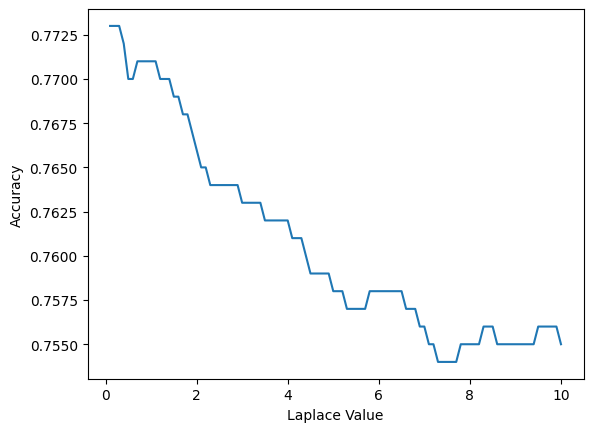

In [ ]:
import matplotlib.pyplot as plt

laplaces = []
accuracies = []
for i in range(1, 101):
    laplace = i * 0.1
    nb.fit(train_images, train_labels, laplace)
    predict_labels = []
    for test_image in test_images:
        predict_labels.append(nb.predict(test_image))
    laplaces.append(laplace)
    accuracies.append(nb.accuracy(test_labels, predict_labels))

accuracies = np.asarray(accuracies)
print("Laplace value with highest accuracy: ", laplaces[np.argmax(accuracies)])
plt.plot(laplaces, accuracies)
plt.xlabel('Laplace Value')
plt.ylabel('Accuracy')
plt.show()

K-fold validation

In [1]:
import numpy as np

def preProcess(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    img_list = []
    for line in lines:
        line = line.rstrip("\n\r")
        img_list.append(list(line))

    img_arr = np.array(img_list)
    img_count = int(img_arr.shape[0] / 28)
    img_arr.resize(img_count, 784)

    img_arr[img_arr == '+'] = '1'
    img_arr[img_arr == '#'] = '1'
    img_arr[img_arr == ' '] = '0'

    return img_arr.astype(int)

def readLabels(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    labels = []
    for line in lines:
        labels.append(line.rstrip("\n\r"))
    return np.asarray(labels).astype(int)


class NaiveBayes:
    def __init__(self):
        self.digit_frequency = []
        self.likelihood = []
        self.number_of_samples = 0
        self.number_of_features = 0
    def fit(self, X_train, Y_train, laplace = 0.1):
        _, self.digit_frequency = np.unique(train_labels, return_counts=True)
        self.number_of_samples, self.number_of_features = X_train.shape
        self.likelihood = np.zeros((10, self.number_of_features, 2))
        for digit in range(10):
            # Lấy tất cả train image có label = digit
            digit_mask = Y_train == digit
            digit_images = X_train[digit_mask]

            self.likelihood[digit, :, 0] = (np.sum(digit_images == 0, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)
            self.likelihood[digit, :, 1] = (np.sum(digit_images == 1, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)

    def predict(self, X):
        posteriors = []
        for digit in range(10):
            prior = np.log(self.digit_frequency[digit] / self.number_of_samples)
            log_likelihood = np.sum(np.log([self.likelihood[digit, i, int(X[i])] for i in range(self.number_of_features)]))
            posterior = prior + log_likelihood
            posteriors.append((digit, posterior))

        posteriors = np.asarray(posteriors)
        return int(posteriors[np.argmax(posteriors[:, 1])][0])

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)
def k_fold_validation(X, Y, K, laplace=0.1):
    dataset_size = len(Y)
    fold_size = dataset_size // K
    accuracies = []

    for k in range(K):
        start, end = k * fold_size, (k + 1) * fold_size

        X_test, Y_test = X[start:end], Y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        Y_train = np.concatenate([Y[:start], Y[end:]])

        nb = NaiveBayes()
        nb.fit(X_train, Y_train, laplace)
        predictions = [nb.predict(x_test) for x_test in X_test]

        accuracy = nb.accuracy(Y_test, predictions)
        accuracies.append(accuracy)

    return np.mean(accuracies)

train_images = preProcess("input/trainingimages")
train_labels = readLabels("input/traininglabels")
test_images = preProcess("input/testimages")
test_labels = readLabels("input/testlabels")

all_images = np.concatenate((train_images, test_images))
all_labels = np.concatenate((train_labels, test_labels))
# Trộn dữ liệu
shuffled_indices = np.random.permutation(len(all_labels))
all_images, all_labels = all_images[shuffled_indices], all_labels[shuffled_indices]

K = 5
average_accuracys = []
for i in range(2, 21):
    average_accuracy = k_fold_validation(all_images, all_labels, i)
    average_accuracys.append(average_accuracy)
    print("Average Accuracy:", average_accuracy)


Average Accuracy: 0.6685000000000001
Average Accuracy: 0.6851666666666666
Average Accuracy: 0.7598333333333334
Average Accuracy: 0.7726666666666666
Average Accuracy: 0.7731666666666666
Average Accuracy: 0.7789631605267545
Average Accuracy: 0.7945
Average Accuracy: 0.7754421087754422
Average Accuracy: 0.7843333333333333
Average Accuracy: 0.790325271059216
Average Accuracy: 0.7899999999999999
Average Accuracy: 0.7959285833472385
Average Accuracy: 0.7807076101468624
Average Accuracy: 0.7908333333333335
Average Accuracy: 0.7986666666666666
Average Accuracy: 0.7951203208556149
Average Accuracy: 0.7994661327994661
Average Accuracy: 0.8028404344193819
Average Accuracy: 0.7936666666666665


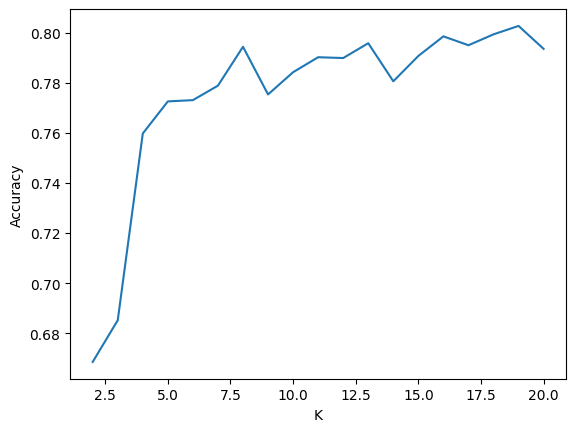

In [2]:
import matplotlib.pyplot as plt
K = list(range(2, 21))
plt.plot(K, average_accuracys)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

Ternary features (Sử dụng 3 giá trị 0, 0.5, 1 cho features)

In [ ]:
import numpy as np

def preProcess(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    img_list = []
    for line in lines:
        line = line.rstrip("\n\r")
        img_list.append(list(line))

    img_arr = np.array(img_list)
    img_count = int(img_arr.shape[0] / 28)
    img_arr.resize(img_count, 784)

    img_arr[img_arr == '+'] = '0.5'
    img_arr[img_arr == '#'] = '1'
    img_arr[img_arr == ' '] = '0'

    return img_arr.astype(float)

def readLabels(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    labels = []
    for line in lines:
        labels.append(line.rstrip("\n\r"))
    return np.asarray(labels).astype(int)

def create_confusion_matrix(y_true, y_pred):
    matrix = np.zeros((10, 10))
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1

    # Convert counts to percentages
    for i in range(10):
        if np.sum(matrix[i]) > 0:
            matrix[i] = (matrix[i] / np.sum(matrix[i])) * 100
    return matrix
class NaiveBayes:
    def __init__(self):
        self.digit_frequency = []
        self.likelihood = []
        self.number_of_samples = 0
        self.number_of_features = 0
    def fit(self, X_train, Y_train, laplace = 0.1):
        _, self.digit_frequency = np.unique(train_labels, return_counts=True)
        self.number_of_samples, self.number_of_features = X_train.shape
        self.likelihood = np.zeros((10, self.number_of_features, 3))
        for digit in range(10):
            # Lấy tất cả train image có label = digit
            digit_mask = Y_train == digit
            digit_images = X_train[digit_mask]
            self.likelihood[digit, :, 0] = (np.sum(digit_images == 0, axis=0) + laplace) / (self.digit_frequency[digit] + 3 * laplace)
            self.likelihood[digit, :, 1] = (np.sum(digit_images == 0.5, axis=0) + laplace) / (self.digit_frequency[digit] + 3 * laplace)
            self.likelihood[digit, :, 2] = (np.sum(digit_images == 1, axis=0) + laplace) / (self.digit_frequency[digit] + 3 * laplace)

    def predict(self, X):
        posteriors = []
        for digit in range(10):
            prior = np.log(self.digit_frequency[digit] / self.number_of_samples)
            log_likelihood = np.sum(np.log([self.likelihood[digit, i, int(X[i]*2)] for i in range(self.number_of_features)]))
            posterior = prior + log_likelihood
            posteriors.append((digit, posterior))


        posteriors = np.asarray(posteriors)
        return int(posteriors[np.argmax(posteriors[:, 1])][0])

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

train_images = preProcess("input/trainingimages")
train_labels = readLabels("input/traininglabels")
test_images = preProcess("input/testimages")
test_labels = readLabels("input/testlabels")

nb = NaiveBayes()
nb.fit(train_images, train_labels)
predict_labels = []
for test_image in test_images:
    predict_labels.append(nb.predict(test_image))

conf_matrix = create_confusion_matrix(test_labels, predict_labels)
df_conf_matrix = pd.DataFrame(conf_matrix, index=[f"Thực tế {i}" for i in range(10)], columns=[f"Dự đoán {i}" for i in range(10)]).applymap(lambda x: f"{x:.2f}")

print("Accuracy:", nb.accuracy(test_labels, predict_labels))
df_conf_matrix

Accuracy: 0.757


,Dự đoán 0,Dự đoán 1,Dự đoán 2,Dự đoán 3,Dự đoán 4,Dự đoán 5,Dự đoán 6,Dự đoán 7,Dự đoán 8,Dự đoán 9
Thực tế 0,83.33,0.00,1.11,1.11,0.00,7.78,4.44,0.00,2.22,0.00
Thực tế 1,0.00,95.37,0.00,0.00,0.00,1.85,0.93,0.00,1.85,0.00
Thực tế 2,1.94,7.77,66.99,5.83,0.97,0.97,5.83,1.94,6.80,0.97
Thực tế 3,0.00,2.00,1.00,79.00,0.00,7.00,1.00,3.00,2.00,5.00
Thực tế 4,0.00,0.00,0.00,0.00,72.90,0.93,1.87,0.93,1.87,21.50
Thực tế 5,1.09,0.00,1.09,7.61,4.35,73.91,1.09,1.09,3.26,6.52
Thực tế 6,0.00,5.49,3.30,0.00,4.40,7.69,78.02,0.00,1.10,0.00
Thực tế 7,0.00,6.60,2.83,0.00,4.72,0.00,0.00,69.81,1.89,14.15
Thực tế 8,0.97,4.85,2.91,7.77,4.85,10.68,0.97,0.97,56.31,9.71
Thực tế 9,1.00,0.00,0.00,2.00,10.00,2.00,0.00,1.00,2.00,82.00


Nhóm các ma trận 2x2 thành 1 feature

In [ ]:
import numpy as np
import pandas as pd

def get_majority_value(block):
    vals, counts = np.unique(block.flatten(), return_counts=True)
    return vals[np.argmax(counts)]

def reduce_image_features(flattened_image):
    reshaped_image = flattened_image.reshape(28, 28)

    reduced_image = np.zeros((14, 14), dtype=reshaped_image.dtype)

    for i in range(0, 28, 2):
        for j in range(0, 28, 2):
            block = reshaped_image[i:i+2, j:j+2]
            reduced_image[i//2, j//2] = get_majority_value(block)

    return reduced_image

def preProcess(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    img_list = []
    for line in lines:
        line = line.rstrip("\n\r")
        img_list.append(list(line))

    img_arr = np.array(img_list)
    img_count = int(img_arr.shape[0] / 28)
    img_arr.resize(img_count, 784)

    img_arr[img_arr == '+'] = '1'
    img_arr[img_arr == '#'] = '1'
    img_arr[img_arr == ' '] = '0'

    newimg_arr = []
    for img in img_arr:
        newimg_arr.append(reduce_image_features(img))
    newimg_arr = np.array(newimg_arr)
    newimg_arr.resize(img_count, 196)

    return newimg_arr.astype(float)

def readLabels(file_path):
    f = open(file_path, encoding="utf-8")
    lines = f.readlines()
    labels = []
    for line in lines:
        labels.append(line.rstrip("\n\r"))
    return np.asarray(labels).astype('int')

def create_confusion_matrix(y_true, y_pred):
    matrix = np.zeros((10, 10))
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1
    for i in range(10):
        if np.sum(matrix[i]) > 0:
            matrix[i] = (matrix[i] / np.sum(matrix[i])) * 100
    return matrix

class NaiveBayes:
    def __init__(self):
        self.digit_frequency = []
        self.likelihood = []
        self.number_of_samples = 0
        self.number_of_features = 0
    def fit(self, X_train, Y_train, laplace = 0.1):
        _, self.digit_frequency = np.unique(train_labels, return_counts=True)
        self.number_of_samples, self.number_of_features = X_train.shape
        self.likelihood = np.zeros((10, self.number_of_features, 2))
        for digit in range(10):
            # Lấy tất cả train image có label = digit
            digit_mask = Y_train == digit
            digit_images = X_train[digit_mask]

            self.likelihood[digit, :, 0] = (np.sum(digit_images == 0, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)
            self.likelihood[digit, :, 1] = (np.sum(digit_images == 1, axis=0) + laplace) / (self.digit_frequency[digit] + 2 * laplace)

    def predict(self, X):
        posteriors = []
        for digit in range(10):
            prior = np.log(self.digit_frequency[digit] / self.number_of_samples)
            log_likelihood = np.sum(np.log([self.likelihood[digit, i, int(X[i])] for i in range(self.number_of_features)]))
            posterior = prior + log_likelihood
            posteriors.append((digit, posterior))

        posteriors = np.asarray(posteriors)
        return int(posteriors[np.argmax(posteriors[:, 1])][0])

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

train_images = preProcess("input/trainingimages")
train_labels = readLabels("input/traininglabels")
test_images = preProcess("input/testimages")
test_labels = readLabels("input/testlabels")

nb = NaiveBayes()
nb.fit(train_images, train_labels)
predict_labels = []
for test_image in test_images:
    predict_labels.append(nb.predict(test_image))

conf_matrix = create_confusion_matrix(test_labels, predict_labels)
df_conf_matrix = pd.DataFrame(conf_matrix, index=[f"Thực tế {i}" for i in range(10)], columns=[f"Dự đoán {i}" for i in range(10)]).applymap(lambda x: f"{x:.2f}")

print("Accuracy:", nb.accuracy(test_labels, predict_labels))
df_conf_matrix

Accuracy: 0.745


,Dự đoán 0,Dự đoán 1,Dự đoán 2,Dự đoán 3,Dự đoán 4,Dự đoán 5,Dự đoán 6,Dự đoán 7,Dự đoán 8,Dự đoán 9
Thực tế 0,81.11,0.00,1.11,0.00,0.00,11.11,4.44,0.00,2.22,0.00
Thực tế 1,0.00,95.37,0.00,0.00,0.00,1.85,0.93,0.00,1.85,0.00
Thực tế 2,0.97,4.85,75.73,1.94,1.94,0.97,5.83,0.97,4.85,1.94
Thực tế 3,0.00,2.00,1.00,74.00,0.00,9.00,1.00,5.00,2.00,6.00
Thực tế 4,0.00,0.00,2.80,0.00,72.90,0.93,3.74,0.00,2.80,16.82
Thực tế 5,1.09,0.00,0.00,11.96,4.35,68.48,1.09,1.09,4.35,7.61
Thực tế 6,2.20,8.79,7.69,0.00,2.20,3.30,73.63,0.00,2.20,0.00
Thực tế 7,0.00,6.60,2.83,0.00,4.72,0.00,0.00,70.75,1.89,13.21
Thực tế 8,1.94,1.94,2.91,12.62,1.94,8.74,0.97,0.97,56.31,11.65
Thực tế 9,1.00,1.00,0.00,2.00,12.00,2.00,0.00,5.00,1.00,76.00
